# **0. Import Library**

In [1]:
import os
import numpy as np
import pandas as pd
import scipy.fftpack
import seaborn as sns
import cloudpickle as pickle
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.io import wavfile
from cvxopt import matrix, solvers
from collections import Counter, defaultdict
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# **1. Data Preprocessing**

### **1.1. Set Important Variables**

In [2]:
base_path = './sounds/'
categories = ['ambulance', 'firetruck', 'traffic']
data_path = []
labels = []

### **1.2. Load Dataset**

In [3]:
for category in categories:
    folder_path = f'sounds/{category}'
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.wav'):
            file_path = os.path.join(folder_path, file_name)
            data_path.append(file_path)
            labels.append(category)

In [4]:
print(f"Number of labels: {len(labels)}")
print(f"Unique labels: {set(labels)}")
label_counts = Counter(labels)
print(f"Number of each label: {dict(label_counts)}")

Number of labels: 600
Unique labels: {'traffic', 'ambulance', 'firetruck'}
Number of each label: {'ambulance': 200, 'firetruck': 200, 'traffic': 200}


### **1.3. Data Augmentation**

In [5]:
def add_noise(signal, noise_level=0.005):
    noise = np.random.randn(len(signal))
    augmented = signal + noise_level * noise
    return augmented.astype(np.float32)

def time_stretch(signal, stretch_factor=1.1):
    indices = np.arange(0, len(signal), stretch_factor)
    indices = indices[indices < len(signal)].astype(int)
    return signal[indices]

def pitch_shift(signal, sr, n_steps=2):
    factor = 2 ** (n_steps / 12)
    resampled = scipy.signal.resample(signal, int(len(signal) / factor))
    if len(resampled) < len(signal):
        pad_width = len(signal) - len(resampled)
        resampled = np.pad(resampled, (0, pad_width), mode='constant')
    else:
        resampled = resampled[:len(signal)]
    return resampled.astype(np.float32)

def volume_perturb(signal, gain=1.2):
    return (signal * gain).astype(np.float32)

def fix_len(sig, target_len):
    if len(sig) < target_len:
        return np.pad(sig, (0, target_len - len(sig)), mode='constant')
    else:
        return sig[:target_len]

In [6]:
def augment_audio(signal, sr):
    aug1 = signal
    aug2 = add_noise(signal)
    aug3 = time_stretch(signal, 1.1)
    aug4 = pitch_shift(signal, sr, n_steps=2)
    aug5 = volume_perturb(signal, gain=0.8)

    original_len = len(signal)
    all_signals = [fix_len(s, original_len) for s in [aug1, aug2, aug3, aug4, aug5]]
    return all_signals

In [7]:
def load_audio(filepath):
    sr, data = wavfile.read(filepath)
    if len(data.shape) > 1:
        data = data[:, 0]
    data = data.astype(np.float32)
    return sr, data

In [8]:
def augment_signal(filepath):
    sr, signal = load_audio(filepath)
    augmented_signals = augment_audio(signal, sr)
    sr_signal_pair = []
    for aug_signal in augmented_signals:
        sr_signal_pair.append((sr, aug_signal))
    return sr_signal_pair

In [9]:
augmented_data = []
for file_path in tqdm(data_path, desc="Augmenting audio files"):
    augmented_data.extend(augment_signal(file_path))
print(f"Total augmented samples: {len(augmented_data)}")

augmented_df = pd.DataFrame(augmented_data, columns=['sample_rate', 'signal'])
augmented_df['label'] = np.repeat(labels, 5)
print(augmented_df)

Augmenting audio files: 100%|██████████| 600/600 [00:22<00:00, 26.98it/s]


Total augmented samples: 3000
      sample_rate                                             signal  \
0           44100  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1           44100  [-4.495439e-05, -0.0044727484, -0.007466108, -...   
2           44100  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3           44100  [14.3213005, -4.9273396, 2.7958882, -1.9206804...   
4           44100  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
...           ...                                                ...   
2995        44100  [-1113.0, -858.0, -563.0, -230.0, 98.0, 357.0,...   
2996        44100  [-1112.9956, -857.9987, -563.0009, -229.99007,...   
2997        44100  [-1113.0, -858.0, -563.0, -230.0, 98.0, 357.0,...   
2998        44100  [-1075.7485, -837.7126, -476.45578, -110.32513...   
2999        44100  [-890.4, -686.4, -450.4, -184.0, 78.4, 285.6, ...   

          label  
0     ambulance  
1     ambulance  
2     ambulance  
3     ambulance  
4     ambulance

# **2. Feature Extraction**

### **2.1. Time Domain**

In [10]:
def time_domain_features(signal):
    zcr = np.mean(np.abs(np.diff(np.sign(signal)))) / 2
    rms = np.sqrt(np.mean(signal**2))
    return zcr, rms

### **2.2. Domain Frekuensi**

In [11]:
def frequency_domain_features(signal, sr):
    N = len(signal)
    fft = np.fft.rfft(signal)
    mag = np.abs(fft)
    freqs = np.fft.rfftfreq(N, d=1/sr)

    spec_centroid = np.sum(freqs * mag) / np.sum(mag)
    spec_bandwidth = np.sqrt(np.sum(((freqs - spec_centroid)**2) * mag) / np.sum(mag))
    rolloff_thresh = 0.85 * np.sum(mag)
    rolloff_freq = freqs[np.where(np.cumsum(mag) >= rolloff_thresh)[0][0]]

    return spec_centroid, spec_bandwidth, rolloff_freq

### **2.3. MFCC Feature**

In [12]:
def hz_to_mel(hz): return 2595 * np.log10(1 + hz / 700.0)
def mel_to_hz(mel): return 700 * (10**(mel / 2595.0) - 1)

def mfcc(signal, sr, n_mfcc=13, n_filters=26, n_fft=512):
    # 1. Framing
    frame_len = int(0.025 * sr)
    frame_step = int(0.010 * sr)
    signal_len = len(signal)
    num_frames = int(np.ceil(float(np.abs(signal_len - frame_len)) / frame_step)) + 1

    pad_len = num_frames * frame_step + frame_len
    z = np.zeros((pad_len - signal_len))
    pad_signal = np.append(signal, z)

    indices = np.tile(np.arange(0, frame_len), (num_frames, 1)) + \
              np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_len, 1)).T
    frames = pad_signal[indices.astype(np.int32, copy=False)]

    # 2. Windowing
    frames *= np.hamming(frame_len)

    # 3. FFT and power spectrum
    mag_frames = np.absolute(np.fft.rfft(frames, n_fft))
    pow_frames = ((1.0 / n_fft) * (mag_frames ** 2))

    # 4. Mel filterbank
    low_mel = hz_to_mel(0)
    high_mel = hz_to_mel(sr / 2)
    mel_points = np.linspace(low_mel, high_mel, n_filters + 2)
    hz_points = mel_to_hz(mel_points)
    bin = np.floor((n_fft + 1) * hz_points / sr).astype(int)

    fbank = np.zeros((n_filters, int(n_fft / 2 + 1)))
    for m in range(1, n_filters + 1):
        f_m_minus, f_m, f_m_plus = bin[m - 1], bin[m], bin[m + 1]
        for k in range(f_m_minus, f_m):
            fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
        for k in range(f_m, f_m_plus):
            fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])

    filter_banks = np.dot(pow_frames, fbank.T)
    filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)
    log_fbanks = np.log(filter_banks)

    # 5. DCT
    mfccs = scipy.fftpack.dct(log_fbanks, type=2, axis=1, norm='ortho')[:, :n_mfcc]
    return np.mean(mfccs, axis=0)


### **2.4. Extract Features From Data**

In [13]:
def extract_all_features(sr, signal):
    zcr, rms = time_domain_features(signal)
    centroid, bandwidth, rolloff = frequency_domain_features(signal, sr)
    mfccs = mfcc(signal, sr)
    return np.array([zcr, rms, centroid, bandwidth, rolloff] + mfccs.tolist())

In [14]:
extracted_data = []
for data in tqdm(augmented_data, desc="Extracting features"):
    sr, signal = data[0], data[1]
    features = extract_all_features(sr, signal)
    extracted_data.append(features)

Extracting features: 100%|██████████| 3000/3000 [00:55<00:00, 54.25it/s]


In [15]:
data_uniform = []
for feature_list in extracted_data:
    processed_features = []
    for feature in feature_list:
        if isinstance(feature, np.ndarray):
            processed_features.append(feature.item())
        else:
            processed_features.append(feature)
    data_uniform.append(processed_features)

X = np.array(data_uniform)
y = np.array(np.repeat(labels, 5))

print(f"Shape of feature matrix X: {X.shape}")
print(f"Shape of label vector y: {y.shape}")

Shape of feature matrix X: (3000, 18)
Shape of label vector y: (3000,)


# **3. Set Up and Train Model**

### **3.1. Support Vector Machine (SVM) Model**

In [16]:
class SVM:
    
    # Fungsi konstruktor untuk menginisialisasi parameter SVM
    def __init__(self, kernel='rbf', C=10.0, degree=3, gamma=0.01):
        self.kernel_type = kernel
        self.C = C
        self.degree = degree
        self.gamma = gamma
        self.models = {}
        self.is_multiclass = False
    
    # Fungsi untuk mendapatkan parameter SVM
    def get_params(self):
        return {
            "C": self.C,
            "kernel": self._compute_kernel,
            "gamma": self.gamma,
            "degree": self.degree,
        }

    # Fungsi untuk mengatur parameter SVM
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self
    
    # Fungsi untuk menghitung kernel
    def _compute_kernel(self, x, y):
        if self.kernel_type == 'linear':
            return np.dot(x, y)
        elif self.kernel_type == 'poly':
            return (1 + self.gamma * np.dot(x, y)) ** self.degree
        elif self.kernel_type == 'rbf':
            return np.exp(-self._gamma * np.linalg.norm(x - y) ** 2)
        else:
            raise ValueError("Unknown kernel")

    # Fungsi untuk melakukan proses fitting model SVM
    def fit(self, X, y):
        self.classes = np.unique(y)
        n_classes = len(self.classes)
        self.is_multiclass = n_classes > 2

        if self.is_multiclass:
            self.models = {}
            print(f"Training {n_classes} OvR SVM models...")
            for cls in tqdm(self.classes, desc="OvR SVM Training"):
                y_binary = np.where(y == cls, 1, -1)
                model = SVM(kernel=self.kernel_type, C=self.C, degree=self.degree, gamma=self.gamma)
                model.fit(X, y_binary)
                self.models[cls] = model
        else:
            y = y.astype(float)
            n_samples, n_features = X.shape
            self.X = X
            self.y = y

            if self.kernel_type == 'rbf':
                self._gamma = self.gamma if self.gamma else 1 / n_features

            # Gram matrix
            K = np.zeros((n_samples, n_samples))
            for i in range(n_samples):
                for j in range(n_samples):
                    K[i, j] = self._compute_kernel(X[i], X[j])

            P = matrix(np.outer(y, y) * K)
            q = matrix(-np.ones(n_samples))
            A = matrix(y.reshape(1, -1))
            b = matrix(0.0)

            if self.C is None:
                G = matrix(-np.eye(n_samples))
                h = matrix(np.zeros(n_samples))
            else:
                G = matrix(np.vstack((-np.eye(n_samples), np.eye(n_samples))))
                h = matrix(np.hstack((np.zeros(n_samples), np.ones(n_samples) * self.C)))

            solvers.options['show_progress'] = False
            solution = solvers.qp(P, q, G, h, A, b)
            alphas = np.ravel(solution['x'])

            # Support vectors
            sv = alphas > 1e-5
            self.alphas = alphas[sv]
            self.support_vectors = X[sv]
            self.support_vector_labels = y[sv]

            # Intercept
            self.b = np.mean([
                y_k - np.sum(self.alphas * self.support_vector_labels *
                             [self._compute_kernel(x_k, x_i) for x_i in self.support_vectors])
                for (x_k, y_k) in zip(self.support_vectors, self.support_vector_labels)
            ])

    # Fungsi untuk menghitung nilai keputusan
    def project(self, X):
        if self.is_multiclass:
            decision_values = np.column_stack([
                model.project(X) for model in self.models.values()
            ])
            return decision_values
        else:
            y_predict = np.zeros(len(X))
            for i in range(len(X)):
                s = 0
                for alpha, sv_y, sv in zip(self.alphas, self.support_vector_labels, self.support_vectors):
                    s += alpha * sv_y * self._compute_kernel(X[i], sv)
                y_predict[i] = s
            return y_predict + self.b
    
    # Fungsi untuk menghitung probabilitas prediksi
    def predict_proba(self, X):
        if not self.is_multiclass:
            raise NotImplementedError("predict_proba hanya didukung untuk mode multiclass OvR")

        decision = self.project(X)
        # Softmax untuk setiap baris
        exp_scores = np.exp(decision - np.max(decision, axis=1, keepdims=True))  # stabilisasi
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        return probs

    # Fungsi untuk melakukan prediksi
    def predict(self, X):
        if self.is_multiclass:
            decision = self.project(X)
            predictions = np.argmax(decision, axis=1)
            return self.classes[predictions]
        else:
            return np.sign(self.project(X))

### **3.2. Train Test Split Data**

In [17]:
# Split data menjadi train (80%) dan test (20%)
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Total dataset: {X.shape[0]} samples")
print(f"Training set: {X_train_raw.shape[0]} samples ({X_train_raw.shape[0]/X.shape[0]*100:.1f}%)")
print(f"Test set: {X_test_raw.shape[0]} samples ({X_test_raw.shape[0]/X.shape[0]*100:.1f}%)")

# Cek distribusi kelas
def print_class_distribution(y, set_name):
    unique, counts = np.unique(y, return_counts=True)
    print(f"\n{set_name}:")
    total = len(y)
    for label, count in zip(unique, counts):
        percentage = count / total * 100
        print(f"  {label}: {count} samples ({percentage:.1f}%)")

print_class_distribution(y_train_raw, "Training Set")
print_class_distribution(y_test_raw, "Test Set")

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

# Encode labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train_raw)
y_test = label_encoder.transform(y_test_raw)

print(f"\nProcessed data shapes:")
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")

print(f"\nLabel mapping: {dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))}")

Total dataset: 3000 samples
Training set: 2400 samples (80.0%)
Test set: 600 samples (20.0%)

Training Set:
  ambulance: 800 samples (33.3%)
  firetruck: 800 samples (33.3%)
  traffic: 800 samples (33.3%)

Test Set:
  ambulance: 200 samples (33.3%)
  firetruck: 200 samples (33.3%)
  traffic: 200 samples (33.3%)

Processed data shapes:
X_train: (2400, 18)
X_test: (600, 18)
y_train: (2400,)
y_test: (600,)

Label mapping: {np.str_('ambulance'): 0, np.str_('firetruck'): 1, np.str_('traffic'): 2}


### **3.3. Grid Search Cross Validation**

In [18]:
def grid_search_cv(X, y, param_grid, cv=5, scoring='accuracy', random_state=None):
    def generate_combinations():
        param_combinations = []
        kernel_params = {
            'linear': ['C'],
            'poly': ['C', 'gamma', 'degree'],
            'rbf': ['C', 'gamma']
        }
        
        for kernel in param_grid['kernel']:
            relevant_params = kernel_params[kernel]
            base_combination = {'kernel': kernel}
            
            def add_params(param_idx=0, current_combination=None):
                if current_combination is None:
                    current_combination = base_combination.copy()
                    
                if param_idx == len(relevant_params):
                    param_combinations.append(current_combination.copy())
                    return
                    
                param_name = relevant_params[param_idx]
                if param_name in param_grid:
                    param_values = param_grid[param_name]
                    for value in param_values:
                        new_combination = current_combination.copy()
                        new_combination[param_name] = value
                        add_params(param_idx + 1, new_combination)
                else:
                    add_params(param_idx + 1, current_combination)
                    
            add_params()
        return param_combinations
    
    def stratified_k_fold(X, y, k=5, random_state=None):
        if random_state is not None:
            np.random.seed(random_state)
            
        # Kelompokkan indeks berdasarkan label kelas
        class_indices = defaultdict(list)
        for idx, label in enumerate(y):
            class_indices[label].append(idx)
            
        # Acakkan indeks dalam setiap kelas
        for label in class_indices:
            np.random.shuffle(class_indices[label])
        
        # Buat k lipatan kosong
        folds = [[] for _ in range(k)]
        
        # Distribusikan sampel dari setiap kelas secara merata
        for label, indices in class_indices.items():
            fold_sizes = np.array([len(indices) // k] * k)
            remainder = len(indices) % k
            if remainder > 0:
                fold_sizes[:remainder] += 1
            
            start_idx = 0
            for fold_idx, size in enumerate(fold_sizes):
                end_idx = start_idx + size
                folds[fold_idx].extend(indices[start_idx:end_idx])
                start_idx = end_idx
                
        return [np.array(fold) for fold in folds]
    
    def cross_validate_params(params, X, y, cv_folds):
        fold_scores = []
        
        for i, val_indices in enumerate(cv_folds):
            # Create train indices (semua fold kecuali fold validation saat ini)
            train_indices = np.concatenate([
                cv_folds[j] for j in range(len(cv_folds)) if j != i
            ])
            
            # Split data training menjadi train dan validation untuk fold ini
            X_train_fold, X_val_fold = X[train_indices], X[val_indices]
            y_train_fold, y_val_fold = y[train_indices], y[val_indices]
            
            # Train model dengan parameter saat ini
            model = SVM(**params)
            model.fit(X_train_fold, y_train_fold)
            
            # Evaluate pada validation fold
            y_pred = model.predict(X_val_fold)
            if scoring == 'accuracy':
                score = accuracy_score(y_val_fold, y_pred)
            else:
                raise ValueError(f"Scoring '{scoring}' not implemented")
                
            fold_scores.append(score)
        
        return np.array(fold_scores)
    
    # Generate parameter combinations
    param_combinations = generate_combinations()
    
    # Prepare CV folds (hanya menggunakan training data)
    cv_folds = stratified_k_fold(X, y, k=cv, random_state=random_state)
    
    # Convert to numpy arrays
    X = np.array(X)
    y = np.array(y)
    
    # Initialize results storage
    best_score = -np.inf
    best_params = None
    cv_results = {
        'params': [],
        'mean_test_score': [],
        'std_test_score': [],
        'rank_test_score': [],
        'split_scores': []
    }
    
    print(f"Fitting {cv} folds for each of {len(param_combinations)} candidates, "
          f"totalling {cv * len(param_combinations)} fits")
    print(f"Training data shape: {X.shape}\n\n")
    
    # Evaluate setiap parameter combination
    for i, params in enumerate(tqdm(param_combinations, desc="Grid Search CV")):
        print(f"\nEvaluating: {params}")
        
        # Perform cross validation pada training data
        fold_scores = cross_validate_params(params, X, y, cv_folds)
        mean_score = np.mean(fold_scores)
        std_score = np.std(fold_scores)
        
        print(f"CV Scores: {fold_scores}")
        print(f"Mean: {mean_score:.4f} (+/- {std_score * 2:.4f})")
        
        # Store results
        cv_results['params'].append(params)
        cv_results['mean_test_score'].append(mean_score)
        cv_results['std_test_score'].append(std_score)
        cv_results['split_scores'].append(fold_scores)
        
        # Update best parameters
        if mean_score > best_score:
            best_score = mean_score
            best_params = params
            print(f"★ New best score: {best_score:.4f}")
    
    # Calculate ranking
    scores_array = np.array(cv_results['mean_test_score'])
    ranks = np.argsort(-scores_array) + 1  # Descending order, 1-indexed
    cv_results['rank_test_score'] = [ranks[i] for i in range(len(ranks))]
    
    # Refit dengan best parameters pada seluruh training data
    print(f"\nRefitting model with best parameters on full training set...")
    best_estimator = SVM(**best_params)
    best_estimator.fit(X, y)
    
    print("\nGRID SEARCH RESULTS\n")
    print(f"Best parameters: {best_params}")
    print(f"Best cross-validation score: {best_score:.4f}")
    
    # Show top 5 results
    print(f"\nTop 5 parameter combinations:")
    sorted_indices = np.argsort(-scores_array)[:5]
    for i, idx in enumerate(sorted_indices):
        params = cv_results['params'][idx]
        score = cv_results['mean_test_score'][idx]
        std = cv_results['std_test_score'][idx]
        print(f"{i+1}. {params}")
        print(f"   Score: {score:.4f} (+/- {std*2:.4f})")
    
    return best_estimator, best_params, best_score, cv_results

In [20]:
# Jalankan Grid Search CV (seperti sklearn)
param_grid = {
    'kernel': ['linear', 'rbf'],
    'C': [0.1, 1.0, 10.0],
    'gamma': [0.001, 0.01, 0.1],
}

print("GRID SEARCH CROSS VALIDATION\n")

# Grid search hanya menggunakan training data
best_model, best_params, best_cv_score, cv_results = grid_search_cv(
    X_train, y_train, param_grid, cv=5, random_state=42
)

# Evaluasi final pada test set (data yang benar-benar unseen)
print("\nFINAL EVALUATION ON TEST SET\n")

y_test_pred = best_model.predict(X_test)
test_score = accuracy_score(y_test, y_test_pred)

print(f"Best CV score (on training data): {best_cv_score:.4f}")
print(f"Test score (on unseen data): {test_score:.4f}")

# Performance analysis
cv_test_gap = best_cv_score - test_score
print(f"CV vs Test gap: {cv_test_gap:.4f}")

if cv_test_gap > 0.05:
    print("⚠️  Warning: Large gap between CV and test scores may indicate overfitting")
elif cv_test_gap < -0.02:
    print("⚠️  Note: Test score higher than CV score - good generalization")
else:
    print("✅ Good model generalization - similar CV and test performance")

print(f"\nBest Parameters: {best_params}")
print(f"Best CV Score: {best_cv_score:.4f}")
print(f"Test Score: {test_score:.4f}")

GRID SEARCH CROSS VALIDATION

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Training data shape: (2400, 18)




Grid Search CV:   0%|          | 0/12 [00:00<?, ?it/s]


Evaluating: {'kernel': 'linear', 'C': 0.1}
Training 3 OvR SVM models...


OvR SVM Training: 100%|██████████| 3/3 [00:53<00:00, 17.79s/it]


Training 3 OvR SVM models...


OvR SVM Training: 100%|██████████| 3/3 [01:41<00:00, 33.92s/it]


Training 3 OvR SVM models...


OvR SVM Training: 100%|██████████| 3/3 [01:52<00:00, 37.61s/it]


Training 3 OvR SVM models...


OvR SVM Training: 100%|██████████| 3/3 [00:56<00:00, 18.77s/it]


Training 3 OvR SVM models...


Grid Search CV:   8%|▊         | 1/12 [07:31<1:22:50, 451.87s/it]

CV Scores: [0.9625     0.93125    0.92291667 0.90625    0.91875   ]
Mean: 0.9283 (+/- 0.0378)
★ New best score: 0.9283

Evaluating: {'kernel': 'linear', 'C': 1.0}
Training 3 OvR SVM models...


OvR SVM Training: 100%|██████████| 3/3 [02:46<00:00, 55.52s/it]


Training 3 OvR SVM models...


OvR SVM Training: 100%|██████████| 3/3 [02:52<00:00, 57.41s/it]


Training 3 OvR SVM models...


OvR SVM Training: 100%|██████████| 3/3 [02:38<00:00, 52.93s/it]


Training 3 OvR SVM models...


OvR SVM Training: 100%|██████████| 3/3 [02:12<00:00, 44.25s/it]


Training 3 OvR SVM models...


Grid Search CV:  17%|█▋        | 2/12 [19:07<1:39:15, 595.51s/it]

CV Scores: [0.95833333 0.93333333 0.93333333 0.92291667 0.93125   ]
Mean: 0.9358 (+/- 0.0238)
★ New best score: 0.9358

Evaluating: {'kernel': 'linear', 'C': 10.0}
Training 3 OvR SVM models...


OvR SVM Training: 100%|██████████| 3/3 [01:02<00:00, 20.82s/it]


Training 3 OvR SVM models...


OvR SVM Training: 100%|██████████| 3/3 [01:08<00:00, 22.84s/it]


Training 3 OvR SVM models...


OvR SVM Training: 100%|██████████| 3/3 [01:04<00:00, 21.37s/it]


Training 3 OvR SVM models...


OvR SVM Training: 100%|██████████| 3/3 [01:10<00:00, 23.46s/it]


Training 3 OvR SVM models...


Grid Search CV:  25%|██▌       | 3/12 [24:45<1:11:38, 477.56s/it]

CV Scores: [0.96041667 0.93333333 0.93541667 0.92083333 0.93541667]
Mean: 0.9371 (+/- 0.0257)
★ New best score: 0.9371

Evaluating: {'kernel': 'rbf', 'C': 0.1, 'gamma': 0.001}
Training 3 OvR SVM models...


OvR SVM Training: 100%|██████████| 3/3 [01:40<00:00, 33.40s/it]


Training 3 OvR SVM models...


OvR SVM Training: 100%|██████████| 3/3 [02:11<00:00, 43.79s/it]


Training 3 OvR SVM models...


OvR SVM Training: 100%|██████████| 3/3 [03:05<00:00, 61.84s/it]


Training 3 OvR SVM models...


OvR SVM Training: 100%|██████████| 3/3 [01:40<00:00, 33.41s/it]


Training 3 OvR SVM models...


Grid Search CV:  33%|███▎      | 4/12 [37:06<1:17:32, 581.54s/it]

CV Scores: [0.91041667 0.89583333 0.88333333 0.85833333 0.88541667]
Mean: 0.8867 (+/- 0.0342)

Evaluating: {'kernel': 'rbf', 'C': 0.1, 'gamma': 0.01}
Training 3 OvR SVM models...


OvR SVM Training: 100%|██████████| 3/3 [01:59<00:00, 39.84s/it]


Training 3 OvR SVM models...


OvR SVM Training: 100%|██████████| 3/3 [01:17<00:00, 25.90s/it]


Training 3 OvR SVM models...


OvR SVM Training: 100%|██████████| 3/3 [01:18<00:00, 26.06s/it]


Training 3 OvR SVM models...


OvR SVM Training: 100%|██████████| 3/3 [01:16<00:00, 25.34s/it]


Training 3 OvR SVM models...


Grid Search CV:  42%|████▏     | 5/12 [44:46<1:02:44, 537.77s/it]

CV Scores: [0.91875    0.91875    0.91666667 0.88333333 0.89791667]
Mean: 0.9071 (+/- 0.0285)

Evaluating: {'kernel': 'rbf', 'C': 0.1, 'gamma': 0.1}
Training 3 OvR SVM models...


OvR SVM Training: 100%|██████████| 3/3 [01:31<00:00, 30.44s/it]


Training 3 OvR SVM models...


OvR SVM Training: 100%|██████████| 3/3 [01:19<00:00, 26.36s/it]


Training 3 OvR SVM models...


OvR SVM Training: 100%|██████████| 3/3 [01:16<00:00, 25.42s/it]


Training 3 OvR SVM models...


OvR SVM Training: 100%|██████████| 3/3 [01:14<00:00, 24.92s/it]


Training 3 OvR SVM models...


Grid Search CV:  50%|█████     | 6/12 [51:40<49:33, 495.64s/it]  

CV Scores: [0.95416667 0.94791667 0.96458333 0.93541667 0.94583333]
Mean: 0.9496 (+/- 0.0193)
★ New best score: 0.9496

Evaluating: {'kernel': 'rbf', 'C': 1.0, 'gamma': 0.001}
Training 3 OvR SVM models...


OvR SVM Training: 100%|██████████| 3/3 [01:15<00:00, 25.14s/it]


Training 3 OvR SVM models...


OvR SVM Training: 100%|██████████| 3/3 [01:16<00:00, 25.39s/it]


Training 3 OvR SVM models...


OvR SVM Training: 100%|██████████| 3/3 [01:18<00:00, 26.04s/it]


Training 3 OvR SVM models...


OvR SVM Training: 100%|██████████| 3/3 [01:15<00:00, 25.29s/it]


Training 3 OvR SVM models...


Grid Search CV:  58%|█████▊    | 7/12 [58:19<38:40, 464.11s/it]

CV Scores: [0.91041667 0.90208333 0.90416667 0.87291667 0.8875    ]
Mean: 0.8954 (+/- 0.0271)

Evaluating: {'kernel': 'rbf', 'C': 1.0, 'gamma': 0.01}
Training 3 OvR SVM models...


OvR SVM Training: 100%|██████████| 3/3 [01:14<00:00, 24.83s/it]


Training 3 OvR SVM models...


OvR SVM Training: 100%|██████████| 3/3 [01:15<00:00, 25.19s/it]


Training 3 OvR SVM models...


OvR SVM Training: 100%|██████████| 3/3 [01:13<00:00, 24.40s/it]


Training 3 OvR SVM models...


OvR SVM Training: 100%|██████████| 3/3 [01:13<00:00, 24.63s/it]


Training 3 OvR SVM models...


Grid Search CV:  67%|██████▋   | 8/12 [1:04:42<29:13, 438.46s/it]

CV Scores: [0.95416667 0.94166667 0.95       0.92083333 0.93333333]
Mean: 0.9400 (+/- 0.0239)

Evaluating: {'kernel': 'rbf', 'C': 1.0, 'gamma': 0.1}
Training 3 OvR SVM models...


OvR SVM Training: 100%|██████████| 3/3 [01:11<00:00, 23.87s/it]


Training 3 OvR SVM models...


OvR SVM Training: 100%|██████████| 3/3 [01:13<00:00, 24.57s/it]


Training 3 OvR SVM models...


OvR SVM Training: 100%|██████████| 3/3 [01:15<00:00, 25.03s/it]


Training 3 OvR SVM models...


OvR SVM Training: 100%|██████████| 3/3 [01:11<00:00, 23.98s/it]


Training 3 OvR SVM models...


Grid Search CV:  75%|███████▌  | 9/12 [1:11:00<20:58, 419.48s/it]

CV Scores: [0.98958333 0.975      0.98125    0.96041667 0.98541667]
Mean: 0.9783 (+/- 0.0203)
★ New best score: 0.9783

Evaluating: {'kernel': 'rbf', 'C': 10.0, 'gamma': 0.001}
Training 3 OvR SVM models...


OvR SVM Training: 100%|██████████| 3/3 [01:20<00:00, 26.85s/it]


Training 3 OvR SVM models...


OvR SVM Training: 100%|██████████| 3/3 [01:21<00:00, 27.12s/it]


Training 3 OvR SVM models...


OvR SVM Training: 100%|██████████| 3/3 [01:18<00:00, 26.17s/it]


Training 3 OvR SVM models...


OvR SVM Training: 100%|██████████| 3/3 [01:21<00:00, 27.32s/it]


Training 3 OvR SVM models...


Grid Search CV:  83%|████████▎ | 10/12 [1:17:56<13:56, 418.38s/it]

CV Scores: [0.94166667 0.93333333 0.92708333 0.90833333 0.9125    ]
Mean: 0.9246 (+/- 0.0251)

Evaluating: {'kernel': 'rbf', 'C': 10.0, 'gamma': 0.01}
Training 3 OvR SVM models...


OvR SVM Training: 100%|██████████| 3/3 [01:19<00:00, 26.42s/it]


Training 3 OvR SVM models...


OvR SVM Training: 100%|██████████| 3/3 [01:19<00:00, 26.58s/it]


Training 3 OvR SVM models...


OvR SVM Training: 100%|██████████| 3/3 [01:20<00:00, 26.95s/it]


Training 3 OvR SVM models...


OvR SVM Training: 100%|██████████| 3/3 [01:19<00:00, 26.40s/it]


Training 3 OvR SVM models...


Grid Search CV:  92%|█████████▏| 11/12 [1:24:45<06:55, 415.62s/it]

CV Scores: [0.97291667 0.96875    0.975      0.95833333 0.97708333]
Mean: 0.9704 (+/- 0.0133)

Evaluating: {'kernel': 'rbf', 'C': 10.0, 'gamma': 0.1}
Training 3 OvR SVM models...


OvR SVM Training: 100%|██████████| 3/3 [01:13<00:00, 24.46s/it]


Training 3 OvR SVM models...


OvR SVM Training: 100%|██████████| 3/3 [01:14<00:00, 24.98s/it]


Training 3 OvR SVM models...


OvR SVM Training: 100%|██████████| 3/3 [01:13<00:00, 24.54s/it]


Training 3 OvR SVM models...


OvR SVM Training: 100%|██████████| 3/3 [01:13<00:00, 24.55s/it]


Training 3 OvR SVM models...


Grid Search CV: 100%|██████████| 12/12 [1:31:01<00:00, 455.16s/it]


CV Scores: [0.99375    0.99375    0.99166667 0.97083333 0.99583333]
Mean: 0.9892 (+/- 0.0185)
★ New best score: 0.9892

Refitting model with best parameters on full training set...
Training 3 OvR SVM models...


OvR SVM Training: 100%|██████████| 3/3 [02:04<00:00, 41.50s/it]



GRID SEARCH RESULTS

Best parameters: {'kernel': 'rbf', 'C': 10.0, 'gamma': 0.1}
Best cross-validation score: 0.9892

Top 5 parameter combinations:
1. {'kernel': 'rbf', 'C': 10.0, 'gamma': 0.1}
   Score: 0.9892 (+/- 0.0185)
2. {'kernel': 'rbf', 'C': 1.0, 'gamma': 0.1}
   Score: 0.9783 (+/- 0.0203)
3. {'kernel': 'rbf', 'C': 10.0, 'gamma': 0.01}
   Score: 0.9704 (+/- 0.0133)
4. {'kernel': 'rbf', 'C': 0.1, 'gamma': 0.1}
   Score: 0.9496 (+/- 0.0193)
5. {'kernel': 'rbf', 'C': 1.0, 'gamma': 0.01}
   Score: 0.9400 (+/- 0.0239)

FINAL EVALUATION ON TEST SET

Best CV score (on training data): 0.9892
Test score (on unseen data): 0.9983
CV vs Test gap: -0.0092
✅ Good model generalization - similar CV and test performance

Best Parameters: {'kernel': 'rbf', 'C': 10.0, 'gamma': 0.1}
Best CV Score: 0.9892
Test Score: 0.9983


# **4. Evaluate Model**

### **4.1. Labels Prediction**

In [21]:
best_model = SVM(**best_params)
best_model.fit(X_train, y_train)

Training 3 OvR SVM models...


OvR SVM Training: 100%|██████████| 3/3 [03:42<00:00, 74.05s/it] 


In [22]:
y_pred = best_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc*100:.2f}%")

Accuracy: 99.83%


### **4.2. Metrics Evaluation**

DETAILED EVALUATION

Test Set Classification Report:
              precision    recall  f1-score   support

   ambulance       1.00      0.99      1.00       200
   firetruck       1.00      1.00      1.00       200
     traffic       1.00      1.00      1.00       200

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600



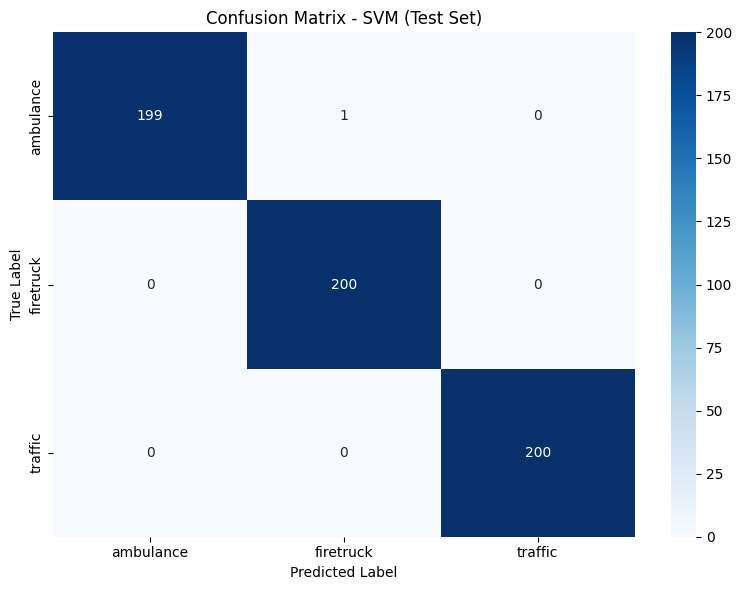

SUMMARY

Total samples: 3000
Training samples: 2400
Test samples: 600
Features: 18
Classes: 3 (ambulance, firetruck, traffic)


In [23]:
print("DETAILED EVALUATION\n")

print("Test Set Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
           xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix - SVM (Test Set)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# Summary
print("SUMMARY\n")
print(f"Total samples: {X.shape[0]}")
print(f"Training samples: {X_train.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")
print(f"Features: {X_train.shape[1]}")
print(f"Classes: {len(label_encoder.classes_)} ({', '.join(label_encoder.classes_)})")

# **5. Export Model**

In [24]:
with open("svm_model.pkl", "wb") as f:
    pickle.dump(best_model, f)

In [25]:
with open("svm_scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

In [26]:
with open("svm_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)